# Fine Tuning Resnet
- Prepare data for training/validation. Create dataloader
- Load in resnet model
- Create architecture for fine tuning including pytorch/tensorflow boilerplate

In [125]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from dotenv import dotenv_values 
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Model

from torchvggish import VGGish
from torchvggish.vggish import load_weights

ModuleNotFoundError: No module named 'torchvggish'

## Data Preparation
- Import data
- Calculate mel specs
- Create data set class for spectrograms/chromagrams/tempograms

In [54]:
explore_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos-old/data/augmented_audio/batch_1_augmented.pkl')
explore_df.head(2)

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,instrumentalness,liveness,valence,tempo,time_signature,processed_audio,augmented_audio,diff_processed_audio,diff_artist,diff_name
10000,TRFNPIK128F9317759,Limelight,Rush,https://p.scdn.co/mp3-preview/6b5b71fc9762eda2...,0dnz7bSs3txd9nGY9e3Mlf,"classic_rock, hard_rock, 80s, progressive_rock",Rock,2006,260066,0.579,...,0.004010,0.286,0.795,131.097,3,"([-0.1274366, -0.21459332, -0.023305148, -0.08...","([-0.18257691, -0.3222155, -0.12718868, -0.017...","([-0.09010448, -0.13527939, -0.14203383, -0.09...",Mr. Big,To Be With You
10001,TRWPWPE128F92CB675,Friends Will Be Friends,Queen,https://p.scdn.co/mp3-preview/771fbc667792ab31...,0nvIhBnscX9w7P2yrqxB6K,"rock, classic_rock, hard_rock, 80s, british",NaN,1986,247840,0.438,...,0.000006,0.345,0.347,75.054,3,"([0.09164546, 0.12546735, 0.06996889, 0.048958...","([0.080816284, 0.06832799, 0.08953604, 0.08095...","([-0.059521385, -0.09814703, 0.0005738288, 0.0...",Eric Clapton,Alberta


In [52]:
explore_df['processed_audio'].values[1][0]
#anchor = torch.tensor(self.anchors[idx], dtype=torch.float32).unsqueeze(0)

array([ 0.09164546,  0.12546735,  0.06996889, ..., -0.2099937 ,
       -0.18352029, -0.16729411], dtype=float32)

In [21]:
# Import data
working_df = pd.read_hdf('../working_df.h5', key='df')
working_df.head(2)

,name,artist,processed_audio,augmented_audio,diff_name,diff_artist,diff_processed_audio
0,Mr. Brightside,The Killers,"([-0.2620229, -0.35404703, -0.3487168, -0.3190...","([-0.3509405, -0.5323735, -0.2839542, -0.24393...",Numb,Linkin Park,"([0.11908126, 0.2909583, 0.30372348, 0.1632980..."
1,Wonderwall,Oasis,"([-0.061054245, -0.17240259, -0.19763069, -0.1...","([0.06728606, -0.09246577, -0.3403954, -0.1606...",Black Hole Sun,Soundgarden,"([0.05073167, 0.06983984, -0.050674707, 0.0196..."


In [22]:
def make_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [23]:
# Apply the function to the DataFrame
tqdm.pandas(desc=f"Making Anchor Mel Spectrograms...")
working_df['anchors'] = working_df['processed_audio'].progress_apply(lambda row: make_mel_spectrogram(row[0], row[1]))
tqdm.pandas(desc=f"Making Similar Mel Spectrograms...")
working_df['positives'] = working_df['augmented_audio'].progress_apply(lambda row: make_mel_spectrogram(row[0], row[1]))
tqdm.pandas(desc=f"Making Differet Mel Spectrograms...")
working_df['negatives'] = working_df['diff_processed_audio'].progress_apply(lambda row: make_mel_spectrogram(row[0], row[1]))

# Create new dataframe
dataset_df = working_df[['anchors', 'positives', 'negatives']]
dataset_df.head(2)

Making Differet Mel Spectrograms...: 100%|██████████| 100/100 [00:02<00:00, 48.76it/s]


,anchors,positives,negatives
0,"[[-26.521116, -30.167957, -26.034828, -18.4934...","[[-25.416304, -29.527111, -26.216137, -18.9720...","[[-33.491425, -34.488136, -31.95215, -30.40233..."
1,"[[-35.544044, -34.28563, -30.778538, -18.86684...","[[-37.14359, -31.460531, -29.60542, -19.17395,...","[[-28.93778, -29.16246, -31.800354, -33.152977..."


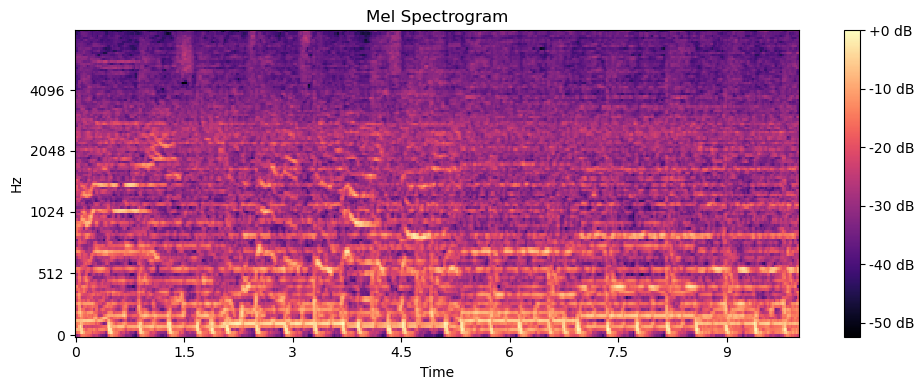

In [5]:
# Plot sample just to check
test_mel_spec = dataset_df['anchors'].iloc[0]

plt.figure(figsize=(10, 4))
librosa.display.specshow(test_mel_spec, sr=22050, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

#### Create Dataset Class

In [2]:
# Dataset class that does include batching
class SpectrogramDataset(Dataset):

    def __init__(self, file_paths, sr=22050, n_mels=128):
        self.file_paths = file_paths
        self.current_file_index = 0

        self.sr = sr
        self.n_mels = n_mels
        self.load_current_file()      
    
    def load_current_file(self):
        # Load data from the current .pkl file
        self.current_data = pd.read_pickle(self.file_paths[self.current_file_index])
        self.current_anchors = self.current_data['processed_audio'].values
        self.current_positives = self.current_data['augmented_audio'].values
        self.current_negatives = self.current_data['diff_processed_audio'].values
        self.current_file_length = len(self.current_anchors)
        self.current_file_index += 1
    
    def __len__(self):
        total_length = sum(pd.read_pickle(file).shape[0] for file in self.file_paths)
        return total_length
    
    def __getitem__(self, idx):
        while idx >= self.current_file_length:
            idx -= self.current_file_length
            if self.current_file_index < len(self.file_paths):
                self.load_current_file()
            else:
                raise IndexError("Index out of range")

        # Load audio data and select idx'th example and get [0] to get audio from (y, sr) tuple
        anchor = self.current_anchors[idx][0]
        positive = self.current_positives[idx][0]
        negative = self.current_negatives[idx][0]

        # Compute mel spectrograms
        anchor_mel = self._process_audio(anchor)
        positive_mel = self._process_audio(positive)
        negative_mel = self._process_audio(negative)

        return anchor_mel, positive_mel, negative_mel
    
    # Convert raw audio to mel spectrogram
    def _process_audio(self, y):
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = torch.tensor(mel_spectrogram_db, dtype=torch.float32).unsqueeze(0)
        return mel_spectrogram_db

### Split Data and Instantiate Dataset Class

In [67]:
# Split data into training and validation sets
#anchors_train, anchors_val, positives_train, positives_val, negatives_train, negatives_val = train_test_split(
#    anchors, positives, negatives, test_size=0.2, random_state=123)

file_paths = [f'../data/augmented_audio/batch_{i}_augmented.pkl' for i in range(1,3,1)]

# Split the files instaed of actual data into training/val
train_files, val_files = train_test_split(file_paths, test_size=0.2, random_state=123)
# Instantiate Dataset Classes

train_dataset = SpectrogramDataset(train_files)
val_dataset = SpectrogramDataset(val_files)
#train_dataset = SpectrogramDataset(anchors_train, positives_train, negatives_train)
#val_dataset = SpectrogramDataset(anchors_val, positives_val, negatives_val)

# Declare dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Delcaring the Model
- Define architecture: default resnet with adjusted first conv layer and final FC layer to set num params
- Choose loss function, optimizer, device, etc.

In [119]:
# Define pretrained resnet from Torch Vision resnet 18
class ResNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        # get resnet super class
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        # Change structure of first layer to take non RGB images, rest of params same as default
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #self.dropout = nn.Dropout(p=dropout_rate)
        # Set the last fully connected to a set dimension "embedding_dim" instead of default 1000
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.resnet(x)
        return F.normalize(x, p=2, dim=1)

In [ ]:
class VGGishEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        super(VGGishEmbedding, self).__init__()
        # Load pre-trained VGGish model
        self.vggish = VGGish()
        load_weights(self.vggish)

        # Add a fully connected layer to get the desired embedding dimension
        self.fc = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = self.vggish(x)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

In [124]:
# Choose model, loss, and optimizer
model = ResNetEmbedding()
criterion = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Declare losses/accuracies
train_losses = []
val_losses = []
baseline_losses = []

num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

OSError: facebook/distilhubert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

### Training Model
- Go in training mode, zero gradients with 

In [70]:
# Loop over epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    running_train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Training {epoch+1}/{num_epochs}", unit="sample")
    #train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    # Loop over batches using dataloaders
    for anchors, positives, negatives in train_loader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

        optimizer.zero_grad()
        
        anchor_embeddings = model(anchors)
        positive_embeddings = model(positives)
        negative_embeddings = model(negatives)
        
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * anchors.size(0)
        # Update the progress bar by the current batch size
        #pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)  # Increment the progress bar
    
          
    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
        #train_loss += loss.item()

    # Get avg train loss over batches
    #train_loss /= len(train_loader)
    
    # Turn on validation/eval mode
    model.eval()
    running_val_loss = 0.0 
    baseline_loss = 0.0   
    val_pbar = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="sample")
    # Turn off gradient updates since we're in validation
    with torch.no_grad():
        # Batch loop 
        for anchors, positives, negatives in val_loader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            #val_loss += loss.item()

            running_val_loss += loss.item() * anchors.size(0)
            # baseline loss
            baseline_loss += criterion(anchors, positives, negatives).item()
            
            # Update the validation progress bar
            #val_pbar.set_postfix({'val_loss': loss.item()})
            val_pbar.update(1)  # Increment the progress bar
    
    # Calculate average validation loss over the entire dataset
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)  

    baseline_avg_loss = baseline_loss / len(val_loader.dataset)
    baseline_losses.append(baseline_avg_loss)
    # Get average val loss over batches
    #val_loss /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Baseline Loss: {baseline_avg_loss:.4f}")
    
    with open('training_logs.pkl', 'wb') as f:
        pkl.dump((train_losses, val_losses), f)

Training 10/10: 100%|██████████| 32/32 [30:03:47<00:00, 3382.10s/sample]

Validation 10/10: 100%|██████████| 32/32 [30:05:31<00:00, 3385.36s/sample]


































Epoch [1/25], Train Loss: 0.4687, Val Loss: 0.4035, Baseline Loss: 1.3982


Validation 1/25: 100%|██████████| 32/32 [18:13<00:00, 34.16s/sample]


Epoch [2/25], Train Loss: 0.1798, Val Loss: 0.3090, Baseline Loss: 1.3982



Training 2/25: 100%|██████████| 32/32 [18:06<00:00, 33.97s/sample]
































Validation 3/25: 100%|██████████| 32/32 [04:58<00:00,  7.34s/sample]

Epoch [3/25], Train Loss: 0.1014, Val Loss: 0.2792, Baseline Loss: 1.3982


Training 3/25: 100%|██████████| 32/32 [17:55<00:00, 33.61s/sample]

Validation 3/25: 100%|██████████| 32/32 [18:34<00:00, 34.84s/sample]


































Epoch [4/25], Train Loss: 0.0632, Val Loss: 0.2633, Baseline Loss: 1.3982


Validation 4/25: 100%|██████████| 32/32 [18:45<00:00, 35.18s/sample]


Epoch [5/25], Train Loss: 0.0422, Val Loss: 0.2484, Baseline Loss: 1.3982



Training 5/25: 100%|██████████| 32/32 [18:28<00:00, 34.65s/sample]
































Validation 6/25: 100%|██████████| 32/32 [04:42<00:00,  6.91s/sample]

Epoch [6/25], Train Loss: 0.0254, Val Loss: 0.2574, Baseline Loss: 1.3982


Training 6/25: 100%|██████████| 32/32 [17:31<00:00, 32.87s/sample]

Validation 6/25: 100%|██████████| 32/32 [18:01<00:00, 33.81s/sample]


































Epoch [7/25], Train Loss: 0.0184, Val Loss: 0.2664, Baseline Loss: 1.3982


Validation 7/25: 100%|██████████| 32/32 [18:07<00:00, 33.97s/sample]


Epoch [8/25], Train Loss: 0.0136, Val Loss: 0.2586, Baseline Loss: 1.3982



Training 8/25: 100%|██████████| 32/32 [18:27<00:00, 34.59s/sample]
































Validation 9/25: 100%|██████████| 32/32 [05:08<00:00,  7.46s/sample]

Epoch [9/25], Train Loss: 0.0117, Val Loss: 0.2613, Baseline Loss: 1.3982


Training 9/25: 100%|██████████| 32/32 [18:50<00:00, 35.33s/sample]

Validation 9/25: 100%|██████████| 32/32 [18:31<00:00, 34.73s/sample]


































Epoch [10/25], Train Loss: 0.0086, Val Loss: 0.2471, Baseline Loss: 1.3982


Validation 10/25: 100%|██████████| 32/32 [17:59<00:00, 33.75s/sample]


Epoch [11/25], Train Loss: 0.0072, Val Loss: 0.2505, Baseline Loss: 1.3982



Training 11/25: 100%|██████████| 32/32 [1:17:55<00:00, 146.10s/sample]
































Validation 12/25: 100%|██████████| 32/32 [35:06<00:00, 52.42s/sample]

Epoch [12/25], Train Loss: 0.0069, Val Loss: 0.2491, Baseline Loss: 1.3982


Training 12/25: 100%|██████████| 32/32 [2:09:17<00:00, 242.41s/sample]

Validation 12/25: 100%|██████████| 32/32 [2:06:44<00:00, 237.64s/sample]


































Epoch [13/25], Train Loss: 0.0055, Val Loss: 0.2639, Baseline Loss: 1.3982


Training 14/25:   9%|▉         | 3/32 [03:41<38:14, 79.13s/sample]

KeyboardInterrupt: 

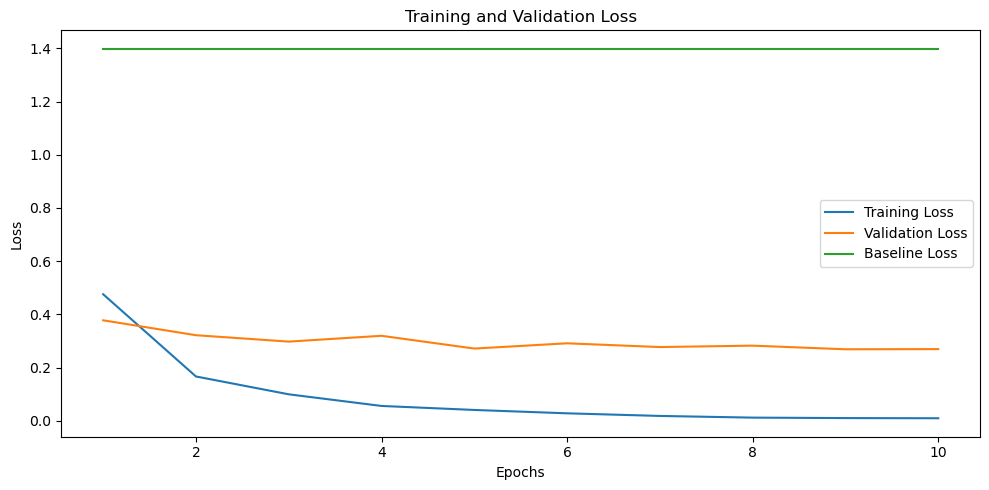

In [ ]:
# Plot loss curves for training
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, baseline_losses, label='Baseline Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig('../images/resnet-loss-plot.png')
plt.show()


In [ ]:
# Save just the model weights (recommended apparently for portability/compatibility)
torch.save(model.state_dict(), 'resnet18_model_weights.pth')

In [18]:
# Save the entire model so we can use it for deployment
torch.save(model, 'resnet18_model.pth')

### Deploy on any 2 songs
- Use model to calculate embeddings (using eval mode specifically and with no gradient updating)
- NOTE: Right now, we have to have the input data in the correct format: a spectrogram/chromagram/tempogram (generically called "gram"). So for any deployment, we'll have to do preprocessing in the streamlit app for example. OR we can have a set of say 10-15 sample songs you can compare where we've already done all of the calculations.
- **Similarity values key:**
    - 0.5 to 1: Very similar. Perhaps the same song.
    - 0 to 0.5: Somewhat similar. Share some key characteristics
    - -1 to 0: Low to no similarity. Different songs.


In [72]:
# How to load the model later using just the state dictionary
model = ResNetEmbedding()  # Make sure this matches the architecture you used
model.load_state_dict(torch.load('resnet18_model_weights.pth'))

# If using a GPU
model.to(device)

ResNetEmbedding(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [115]:
def extract_embedding(model, audio_data_clip, sr=22050, use_model=True):
    y = audio_data_clip
    #y, sr = librosa.load(audio_data_clip, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Convert to tensor and move to the appropriate device
    mel_tensor = torch.tensor(mel_spectrogram_db, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    if use_model:
        # Get the embedding from the model
        with torch.no_grad():
            embedding = model(mel_tensor)
        
        # Normalize the embedding
        #embedding = F.normalize(embedding, p=2, dim=1)
        return embedding
    else:
        return mel_tensor


def compute_cosine_similarity(embedding1, embedding2):
    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(embedding1, embedding2)
    return cosine_sim.item()  # Convert to a Python float


In [84]:
explore_df.head(2)

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,instrumentalness,liveness,valence,tempo,time_signature,processed_audio,augmented_audio,diff_processed_audio,diff_artist,diff_name
10000,TRFNPIK128F9317759,Limelight,Rush,https://p.scdn.co/mp3-preview/6b5b71fc9762eda2...,0dnz7bSs3txd9nGY9e3Mlf,"classic_rock, hard_rock, 80s, progressive_rock",Rock,2006,260066,0.579,...,0.004010,0.286,0.795,131.097,3,"([-0.1274366, -0.21459332, -0.023305148, -0.08...","([-0.18257691, -0.3222155, -0.12718868, -0.017...","([-0.09010448, -0.13527939, -0.14203383, -0.09...",Mr. Big,To Be With You
10001,TRWPWPE128F92CB675,Friends Will Be Friends,Queen,https://p.scdn.co/mp3-preview/771fbc667792ab31...,0nvIhBnscX9w7P2yrqxB6K,"rock, classic_rock, hard_rock, 80s, british",NaN,1986,247840,0.438,...,0.000006,0.345,0.347,75.054,3,"([0.09164546, 0.12546735, 0.06996889, 0.048958...","([0.080816284, 0.06832799, 0.08953604, 0.08095...","([-0.059521385, -0.09814703, 0.0005738288, 0.0...",Eric Clapton,Alberta


In [116]:
# Test on some random training/validation data as sanity check
y1, y2 = explore_df['processed_audio'][10000][0], explore_df['diff_processed_audio'][10000][0]
mel1, mel2 = extract_embedding(model, y1), extract_embedding(model, y2)
compute_cosine_similarity(mel1, mel2)

0.7248122692108154

In [127]:
# Test on some random training/validation data as sanity check
y1, y3 = explore_df['processed_audio'][10000][0], explore_df['augmented_audio'][10000][0]
mel1, mel3 = extract_embedding(model, y1), extract_embedding(model, y3)
compute_cosine_similarity(mel1, mel3)

0.8323057889938354

In [128]:
criterion(mel1, mel2, mel3)

tensor(1.)

In [74]:
# Paths to the audio files (these should be the paths to your actual song files)
anchor = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/coversongs/covers32k/A_Whiter_Shade_Of_Pale/annie_lennox+Medusa+03-A_Whiter_Shade_Of_Pale.mp3'
positive = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/coversongs/covers32k/A_Whiter_Shade_Of_Pale/procol_harum+Greatest_Hits+2-A_Whiter_Shade_Of_Pale.mp3'
negative = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/coversongs/covers32k/Abracadabra/steve_miller_band+Steve_Miller_Band_Live_+09-Abracadabra.mp3'

# Extract embeddings for both songs
embedding1 = extract_embedding(model, anchor)
embedding2 = extract_embedding(model, positive)
embedding3 = extract_embedding(model, negative)

In [75]:
# Calculate cosine similarity between the two embeddings
print(f"Cosine Similarity between song and known cover: {compute_cosine_similarity(embedding1, embedding2):.4f}")
print(f"Cosine Similarity between song and random other song: {compute_cosine_similarity(embedding1, embedding3):.4f}")

Cosine Similarity between song and known cover: 0.9788
Cosine Similarity between song and random other song: 0.9790


In [76]:
compute_cosine_similarity(embedding2, embedding3)

0.972726583480835

In [66]:
embed1 = extract_embedding(model, explore_df.processed_audio[10000][0])

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 220500]

In [36]:
print(f"Cosine Similarity between song and known cover (raw): {compute_cosine_similarity(embedding1, embedding2, use_model=False):.4f}")
print(f"Cosine Similarity between song and random other song (raw): {compute_cosine_similarity(embedding1, embedding3, use_model=False):.4f}")

TypeError: compute_cosine_similarity() got an unexpected keyword argument 'use_model'

In [33]:
# Try triplet loss between these 3 songs
print(f"Triplet Loss between songs: {criterion(embedding1, embedding2, embedding3)}")

Triplet Loss between songs: 1.0010606050491333


In [38]:
# try using baseline
baseline_anchor = extract_embedding(model, anchor, use_model=False)
baseline_positive = extract_embedding(model, positive, use_model=False)
baseline_negative = extract_embedding(model, negative, use_model=False)
#print(f"Triplet loss with baseline: {criterion(baseline_anchor, baseline_positive, baseline_negative)}")

In [40]:
baseline_anchor.shape

torch.Size([1, 1, 128, 13641])

In [42]:
baseline_positive.shape

torch.Size([1, 1, 128, 10370])

In [45]:
F.normalize(baseline_positive, p=2, dim=1).shape

torch.Size([1, 1, 128, 10370])